In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

import functions as fun

In [2]:
# Loading data sets
full_data_BatchA = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/data/full_data_BatchA.csv')
y = full_data_BatchA['Label'].to_numpy()
X_morgan = full_data_BatchA.drop(['Label'], axis = 1).to_numpy()

In [3]:
#Only default values exept random state for replications
svm_clf1 = svm.SVC(random_state = 0, probability=True)
knn_clf1 = KNeighborsClassifier(n_jobs=-1)
rf_clf1 = RandomForestClassifier(max_depth=10, random_state=0, n_jobs = -1)
ada_clf1 = AdaBoostClassifier(n_estimators=10, random_state=0)

In [4]:
# Parameters for ML model
train_size = 0.1
test_size = 0.3
#n_neighbours = 3

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [5]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 361
The inicial pool set has size 3258
The inicial test set has size 1552


In [6]:
# Parameters for AL
N_QUERIES = int(2*len(x_pool)/3)

#Timer
tic=timeit.default_timer()

cf_mat_x_clssifr = []
prfmc_x_classifr = []
Classifiers = [knn_clf1, rf_clf1, ada_clf1]
save = True
for classifier in Classifiers:
    
    print(f'********** Training with {str(classifier)}')
    
    prfmc_his, cf_mat_his, learner= fun.active_learnig_train(n_queries = N_QUERIES, x_train = x_train, y_train = y_train, 
                                               x_test = x_test, y_test = y_test, x_pool = x_pool, 
                                               y_pool = y_pool, Classifier = classifier, query_str = entropy_sampling)
    prfmc_x_classifr.append(prfmc_his)
    cf_mat_x_clssifr.append(cf_mat_his)
    
    #Saving model
    if save:
        filename = "".join(["/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/us_entropy_default_models/", str(classifier),'.sav'])
        pickle.dump(learner, open(filename, 'wb'))
    
toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

********** Training with KNeighborsClassifier(n_jobs=-1)
Accuracy after query 1: 0.9903
Accuracy after query 101: 0.9903
Accuracy after query 201: 0.9903
Accuracy after query 301: 0.9903
Accuracy after query 401: 0.9903
Accuracy after query 501: 0.9903
Accuracy after query 601: 0.9903
Accuracy after query 701: 0.9903
Accuracy after query 801: 0.9903
Accuracy after query 901: 0.9903
Accuracy after query 1001: 0.9903
Accuracy after query 1101: 0.9903
Accuracy after query 1201: 0.9903
Accuracy after query 1301: 0.9903
Accuracy after query 1401: 0.9903
Accuracy after query 1501: 0.9903
Accuracy after query 1601: 0.9903
Accuracy after query 1701: 0.9903
Accuracy after query 1801: 0.9903
Accuracy after query 1901: 0.9903
Accuracy after query 2001: 0.9903
Accuracy after query 2101: 0.9903
********** Training with RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=0)
Accuracy after query 1: 0.9903
Accuracy after query 101: 0.9903
Accuracy after query 201: 0.9903
Accuracy after query 

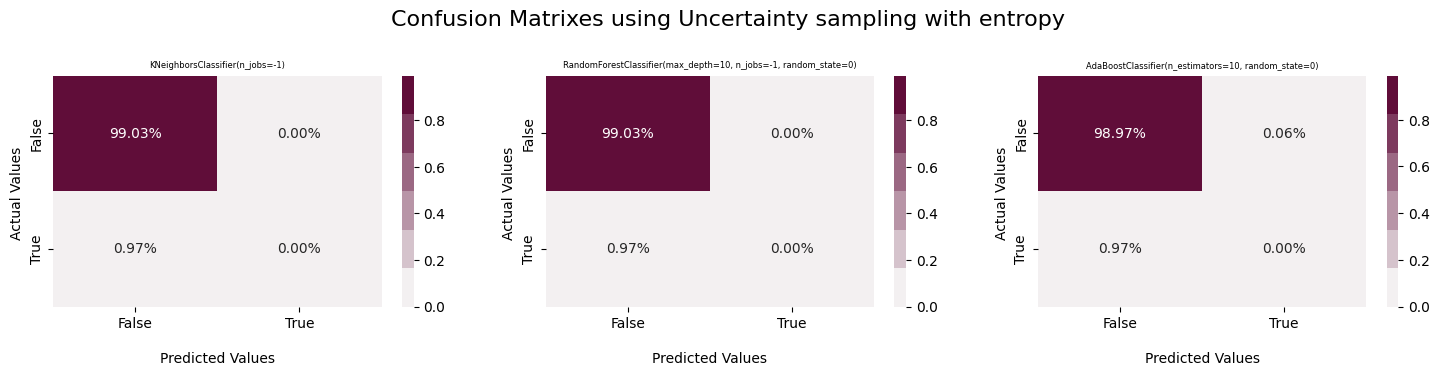

In [10]:
#Plot
clfs_names = [str(x) for x in Classifiers]
fig, axes = plt.subplots(1, 3, figsize=(18,3))
i = 0
for row in axes:
    clf = clfs_names[i]
    fun.plot_cf_mat(matrix = cf_mat_x_clssifr[i][-1], sub_title = clf ,save = False, figure_name = None, ax=row)
    i+=1
fig.suptitle('Confusion Matrixes using Uncertainty sampling with entropy\n', fontsize=16, y =1.1)
plt.show()